In [1]:
%load_ext autoreload
%autoreload 2

In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("darkgrid")
sns.set_palette("dark")

from pipeline.preprocessing import preprocess
from pipeline.walkforward import WFCVGenerator
from config.config_types import AppConfig
import torch

from utils.paths import CONFIG_DIR, SP500COPY_PATH, SP500_PATH, DATA_DIR, VOL_EXPERIMENTS_DIR

DEVICE = "cuda"

In [3]:
df_sp = pd.read_parquet(SP500_PATH)
df_sp

,permno,date,ret,close,vol,open,high,low,cfacpr
0,10078,2000-01-03,-0.012107,76.5,15270527.0,79.25,79.375,74.5,0.5
1,10078,2000-01-04,-0.062092,71.75,21098710.0,73.4375,75.25,71.5,0.5
2,10078,2000-01-05,0.001742,71.875,30073258.0,70.125,73.5,66.625,0.5
3,10078,2000-01-06,-0.053913,68.0,22741999.0,70.4375,71.875,67.0,0.5
4,10078,2000-01-07,0.056985,71.875,20450260.0,67.1875,72.0,66.75,0.5
...,...,...,...,...,...,...,...,...,...
155298,93436,2024-12-24,0.073572,462.28,59351506.0,435.89999,462.78,435.14001,1.0
155299,93436,2024-12-26,-0.01763,454.13,76392273.0,465.16,465.3299,451.01999,1.0
155300,93436,2024-12-27,-0.049479,431.66,82370345.0,449.51999,450.0,426.5,1.0
155301,93436,2024-12-30,-0.033012,417.41,64705452.0,419.39999,427.0,415.75,1.0


- de-comment this to predict a single stock and see how it performs in predicting

In [4]:
#df = preprocess()
#
##permno = np.random.choice(df["permno"].unique())
##print(permno)
#permno = 82307
#df_permno = df[df["permno"]==permno]
#df_permno["var"].plot(kind="line")

In [5]:
#df_permno["t"] = range(len(df_permno))
#df_permno 

In [6]:
cfg_mlp = AppConfig.from_dict(f"{CONFIG_DIR}/vol_mlp.yaml")
cfg_cnn = AppConfig.from_dict(f"{CONFIG_DIR}/vol_cnn.yaml")
cfg_lstm = AppConfig.from_dict(f"{CONFIG_DIR}/vol_lstm.yaml")
#wf = WFCVGenerator(cfg_cnn.walkforward, df_long=df_permno)
wf = WFCVGenerator(cfg_lstm.walkforward)
wf.df_master


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,y,window
0,0.384798,0.276643,1.156039,0.500828,0.279505,0.447830,0.681163,0.217379,0.164337,0.154433,...,0.654951,0.222019,0.249885,0.497562,0.416215,2.106628,0.623645,2.084225,1.383864,"(0, 100)"
1,1.377415,1.398095,1.325630,1.171706,0.588999,0.666737,0.275859,0.433039,0.349256,0.433867,...,0.829535,0.109402,0.268740,0.410897,0.423512,1.502380,0.661611,1.213252,0.904628,"(0, 100)"
2,0.411432,0.221040,0.429308,0.271035,0.191353,0.042433,0.277851,0.156934,0.477721,0.493368,...,0.052280,0.062987,0.065839,0.058498,0.058983,0.224135,0.179045,0.241509,0.188328,"(0, 100)"
3,0.392214,0.101336,0.327422,0.192267,0.085394,0.074611,0.102505,0.103072,0.587274,0.040923,...,0.915136,0.380509,0.188292,0.116515,0.114826,0.353891,0.185980,0.083590,0.038950,"(0, 100)"
4,0.122702,0.218243,0.079012,0.100936,0.177218,0.087669,0.042488,0.016768,0.008718,0.054497,...,0.192869,0.055367,0.032554,0.069122,0.053983,0.123718,0.101190,0.043313,0.106407,"(0, 100)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3046922,0.076223,0.041822,0.142461,0.127446,0.057975,0.175977,0.042434,0.055359,0.042932,0.088698,...,0.130690,0.156978,0.085138,0.115248,0.017775,0.048616,0.034484,0.048312,0.043209,"(6188, 6288)"
3046923,0.153951,0.096554,0.109997,0.068140,0.093264,0.039770,0.053866,0.015413,0.046790,0.029720,...,0.218922,0.083131,0.146927,0.037950,0.016632,0.009928,0.038328,0.041232,0.044974,"(6188, 6288)"
3046924,0.174555,0.051971,0.056239,0.089700,0.078159,0.017632,0.040175,0.021875,0.065935,0.046093,...,0.163122,0.081115,0.088593,0.049059,0.029449,0.056637,0.071445,0.145255,0.031111,"(6188, 6288)"
3046925,0.051733,0.014337,0.031880,0.064745,0.056526,0.039300,0.028445,0.013779,0.015451,0.009678,...,0.078061,0.065953,0.045175,0.035284,0.039051,0.011320,0.011278,0.033625,0.011922,"(6188, 6288)"


In [7]:
test_data = {}
data = {}



for i, fold_data in enumerate(wf.folds()):
    size = fold_data[4]
    y_test = fold_data[5]

    test_data[i] = [size, y_test]
    data[i] = fold_data
    print(i)
    #if i == fold_num:
    #    break

0


In [8]:
name_lstm  = "exp_019_lstm_100_search"
name  = "exp_021_mlp_100_search"
name_cnn  = "exp_020_cnn_100_search"
name_lstm_muon  = "exp_026_lstm_100_muon"
name_cnn_lr  = "exp_028_cnn_100_lr"
trial = "trial_search_best"
trial_1 = "trial_000_003" 
fold_num = 0
base_cnn = f"{VOL_EXPERIMENTS_DIR}/{name_cnn}/{trial}/"
base_lstm = f"{VOL_EXPERIMENTS_DIR}/{name_lstm}/{trial}/"
base_muon = f"{VOL_EXPERIMENTS_DIR}/{name_lstm_muon}/{trial}/"

ckpt_path = f"{base_cnn}fold_{fold_num:03d}/model_best.pt"
ckpt_path_cnn = f"{base_cnn}fold_{fold_num:03d}/model_best.pt"
ckpt_path_lstm = f"{base_lstm}fold_{fold_num:03d}/model_best.pt"
ckpt_path_muon = f"{base_lstm}fold_{fold_num:03d}/model_best.pt"

checkpoint = torch.load(ckpt_path, map_location=DEVICE)
checkpoint_cnn = torch.load(ckpt_path_cnn, map_location=DEVICE)
checkpoint_lstm = torch.load(ckpt_path_lstm, map_location=DEVICE)
checkpoint_muon = torch.load(ckpt_path_muon, map_location=DEVICE)


In [43]:
# Add after loading `checkpoint` and building/instantiating cfg
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import torch
import numpy as np
from models import create_model

def _prepare_X_for_ols(X: np.ndarray) -> np.ndarray:
    X = np.asarray(X)
    if X.ndim == 1:
        return X.reshape(-1, 1)
    if X.ndim == 2:
        return X
    if X.ndim == 3:
        N, T, D = X.shape
        return X.reshape(N, T * D)
    raise ValueError(f"Unexpected X shape for OLS: {X.shape}")

# Replace the existing _infer_input_shape with this version
def _infer_input_shape(cfg, X_sample, state_dict):
    """
    Infer model input_shape from a sample.
    Accepts:
      (T,)          -> univariate row
      (T,D)         -> multivariate row
      (N,T)         -> whole univariate batch
      (N,T,D)       -> whole multivariate batch
    Returns shapes expected by create_model for each architecture.
    """
    name = cfg.model.name.lower()
    shape = X_sample.shape
    # Remove leading batch dimension if accidentally passed
    if X_sample.ndim == 2 and name == "lstm" and shape[0] != cfg.walkforward.lags and shape[1] == cfg.walkforward.lags:
        # Probably (N,T); leave as handled below
        pass

    if name == "lstm":
        # LSTM expects (T,D)
        if X_sample.ndim == 1:              # (T,)
            return (shape[0], 1)
        elif X_sample.ndim == 2:
            if shape[0] == cfg.walkforward.lags and shape[1] != 1:
                # row already (T,D)
                return (shape[0], shape[1])
            elif shape[1] == cfg.walkforward.lags:
                # batch (N,T) -> treat as univariate features
                return (shape[1], 1)
            else:
                # row (T,1) or (T,D)
                return (shape[0], shape[1])
        elif X_sample.ndim == 3:            # (N,T,D)
            return (shape[1], shape[2])
        else:
            raise ValueError(f"Unexpected LSTM sample shape: {shape}")

    elif name == "simplecnn":
        # CNN expects (C,L) with C=1
        if X_sample.ndim == 1:              # (T,)
            return (1, shape[0])
        elif X_sample.ndim == 2:
            if shape[1] == cfg.walkforward.lags and shape[0] != 1:
                # (N,T) batch -> length = T
                return (1, shape[1])
            elif shape[0] == 1:             # (1,T)
                return (1, shape[1])
            else:                           # (T,D) flattened later
                return (1, shape[0]*shape[1])
        elif X_sample.ndim == 3:            # (N,T,D)
            return (1, shape[1])            # treat D collapsed upstream
        else:
            raise ValueError(f"Unexpected CNN sample shape: {shape}")

    elif name == "mlp":
        # MLP expects flattened window (T,) (or T*D)
        if X_sample.ndim == 1:              # (T,)
            return (shape[0],)
        elif X_sample.ndim == 2:
            if shape[1] == cfg.walkforward.lags and shape[0] != cfg.walkforward.lags:
                # (N,T) batch
                return (shape[1],)
            else:                           # (T,D)
                return (shape[0]*shape[1],)
        elif X_sample.ndim == 3:            # (N,T,D)
            return (shape[1]*shape[2],)
        else:
            raise ValueError(f"Unexpected MLP sample shape: {shape}")

    else:
        raise ValueError(f"Unknown model {cfg.model.name}")

@torch.inference_mode()
def _prepare_batch(cfg, x_row):
    name = cfg.model.name.lower()
    # x_row is a single sample slice from X_test
    if name == "mlp":
        if x_row.ndim == 1:
            xb = torch.as_tensor(x_row, dtype=torch.float32).unsqueeze(0)
        elif x_row.ndim == 2:
            xb = torch.as_tensor(x_row.reshape(-1), dtype=torch.float32).unsqueeze(0)
        else:
            raise ValueError
    elif name == "simplecnn":
        # expect (N, C, L); x_row maybe (T,) or (T,D)
        if x_row.ndim == 1:
            xb = torch.as_tensor(x_row, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        elif x_row.ndim == 2:
            # collapse feature dim
            x_flat = x_row.reshape(-1)
            xb = torch.as_tensor(x_flat, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        else:
            raise ValueError
    elif name == "lstm":
        # expect (N, T, D)
        if x_row.ndim == 1:
            xb = torch.as_tensor(x_row, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
        elif x_row.ndim == 2:
            xb = torch.as_tensor(x_row, dtype=torch.float32).unsqueeze(0)
        else:
            raise ValueError
    else:
        raise ValueError
    return xb

def build_model_from_checkpoint(cfg, checkpoint, X_example):
    state_dict = {k.replace("_orig_mod.", ""): v for k, v in checkpoint["model_state"].items()}
    input_shape = _infer_input_shape(cfg, X_example, state_dict)
    output_shape = cfg.walkforward.lookback + 1 if cfg.walkforward.lookback is not None else 1
    model = create_model(cfg.model, input_shape, output_shape)
    model.load_state_dict(state_dict, strict=True)
    model.to(DEVICE).eval()
    return model

@torch.inference_mode()
def infer_sequential(model, cfg, X_test, y_test, limit=None, autoregressive=False, device="cuda"):
    """
    Sequential single-row inference over chronologically sorted X_test.
    For autoregressive=True, we start from X_test[0] and then roll forward
    using our own predictions.
    Returns (y_true, preds) with shape (N, output_dim).
    """
    preds = []
    limit = len(X_test) if limit is None else limit

    if autoregressive:
        # Keep a *list* of windows; each window has same shape as X_test[0]
        X_ar = [np.array(X_test[0], copy=True)]
    else:
        X_ar = None

    for i in range(limit):
        if autoregressive:
            # Always feed the *last* window in the autoregressive buffer
            x_in = X_ar[-1]
        else:
            x_in = X_test[i]

        # Debug: check shapes
        # print("x_in shape:", np.asarray(x_in).shape)

        xb = _prepare_batch(cfg, x_in).to(device)  # should match training input shape
        pb = model(xb).detach().cpu().numpy().reshape(-1)  # (output_dim,)
        preds.append(pb)

        if autoregressive:
            # assume scalar output; if multi-dim adjust accordingly
            next_val = pb[0]

            # x_in is a window of length L; we drop the first element and append the prediction
            x_in = np.asarray(x_in)
            next_window = np.concatenate([x_in[1:], [next_val]])

            # store new window in buffer
            X_ar.append(next_window)

    preds = np.vstack(preds)  # (N, output_dim)
    y_true = np.asarray(y_test[:limit])
    if y_true.ndim == 1:
        y_true = y_true.reshape(-1, 1)

    return y_true, preds

def plot_forecast_overlay(x_input, y_true, y_pred, title="Forecast overlay", horizon_dim: int = 0):
    """
    Plot with an initial burn-in window (the model input) followed by sequential forecasts.
    Assumes:
      x_input: shape (T,) or (T,D)  -> last observed history used for first prediction
      y_true : shape (N, H) or (N,1)
      y_pred : shape (N, H) or (N,1)
    horizon_dim selects which target dimension to display (default 0).
    """
    # Extract burn-in (history) series
    x_input = np.asarray(x_input)
    if x_input.ndim == 2:
        history = x_input[:, horizon_dim] if x_input.shape[1] > horizon_dim else x_input[:, 0]
    else:
        history = x_input.ravel()

    # Extract forecast true/pred series for chosen horizon dimension
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    if y_true.ndim == 2:
        true_future = y_true[:, horizon_dim] if y_true.shape[1] > horizon_dim else y_true[:, 0]
    else:
        true_future = y_true.ravel()
    if y_pred.ndim == 2:
        pred_future = y_pred[:, horizon_dim] if y_pred.shape[1] > horizon_dim else y_pred[:, 0]
    else:
        pred_future = y_pred.ravel()

    T = len(history)
    F = len(true_future)

    # Build unified time index: negative = burn-in, non-negative = forecast
    idx_history = np.arange(-T, 0)
    idx_future  = np.arange(0, F)

    plt.figure(figsize=(12,4))
    plt.plot(idx_history, history, label="History", color="#555555", lw=2)
    plt.plot(idx_future, true_future, label="True Future", color="#1f77b4", lw=2)
    plt.plot(idx_future, pred_future, label="Predicted Future", color="#d62728", lw=2)

    # Vertical separator at forecast start
    plt.axvline(x=-0.5, color="k", linestyle="--", linewidth=1)
    plt.axhline(y=pred_future[0], color="r", linestyle="--", linewidth=1)

    # Metrics
    if len(true_future) == len(pred_future):
        mse = mean_squared_error(true_future, pred_future)
        plt.text(0.9, 0.97, f"MSE={mse:.4g}",
                 transform=plt.gca().transAxes, va="top", ha="left", fontsize=10,
                 bbox=dict(boxstyle="round", fc="white", alpha=0.6, ec="#cccccc"))

    plt.title(f"{title} (dim {horizon_dim})")
    plt.xlabel("Time (negative = burn-in history, >=0 = forecast steps)")
    plt.ylabel("Value")
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    
# ---- Usage example ----
# Assuming data[fold_num] loaded earlier:
Xtr, ytr, Xv, yv, Xte, yte, Xtr_val, ytr_val, Xte_merged, yte_merged = data[fold_num]
X_test_use = Xte  # or Xte_merged if merge mode
y_test_use = yte
print(X_test_use.shape)



# Forecast model
##--------- CNN ---------##
model_cnn = build_model_from_checkpoint(cfg_cnn, checkpoint_cnn, X_test_use[0])
#y_true_seq, y_pred_seq_ar_cnn = infer_sequential(model_cnn, cfg_cnn, X_test_use, y_test_use, limit=200, autoregressive=True)
y_true_seq, y_pred_seq_cnn = infer_sequential(model_cnn, cfg_cnn, X_test_use, y_test_use, limit=200)
#mse_model_cnn = mean_squared_error(y_true_seq[:, 0], y_pred_seq_ar_cnn[:, 0])
#print(f"Test Model MSE: {mse_model_cnn:.6f}")



##--------- LSTM ---------##
model_lstm = build_model_from_checkpoint(cfg_lstm, checkpoint_lstm, X_test_use[0])
#y_true_seq, y_pred_seq_ar_lstm = infer_sequential(model_lstm, cfg_lstm, X_test_use, y_test_use, limit=200, autoregressive=True)
y_true_seq, y_pred_seq_lstm = infer_sequential(model_lstm, cfg_lstm, X_test_use, y_test_use, limit=200)
#mse_model_lstm = mean_squared_error(y_true_seq[:, 0], y_pred_seq_ar_lstm[:, 0])
#print(f"Test Model LSTM MSE: {mse_model_lstm:.6f}")

##--------- LSTM + MUON ---------##
model_muon = build_model_from_checkpoint(cfg_lstm, checkpoint_muon, X_test_use[0])
#y_true_seq, y_pred_seq_ar_muon = infer_sequential(model_muon, cfg_lstm, X_test_use, y_test_use, limit=200, autoregressive=True)
y_true_seq, y_pred_seq_muon = infer_sequential(model_muon, cfg_lstm, X_test_use, y_test_use, limit=200)
#mse_model_muon = mean_squared_error(y_true_seq[:, 0], y_pred_seq_ar_lstm[:, 0])
#print(f"Test Model muon MSE: {mse_model_muon:.6f}")

diff = y_pred_seq_lstm - y_pred_seq_cnn
diff_norm = np.linalg.norm(diff)
print(diff_norm)




(564795, 100)
1.7591385
1.7591385


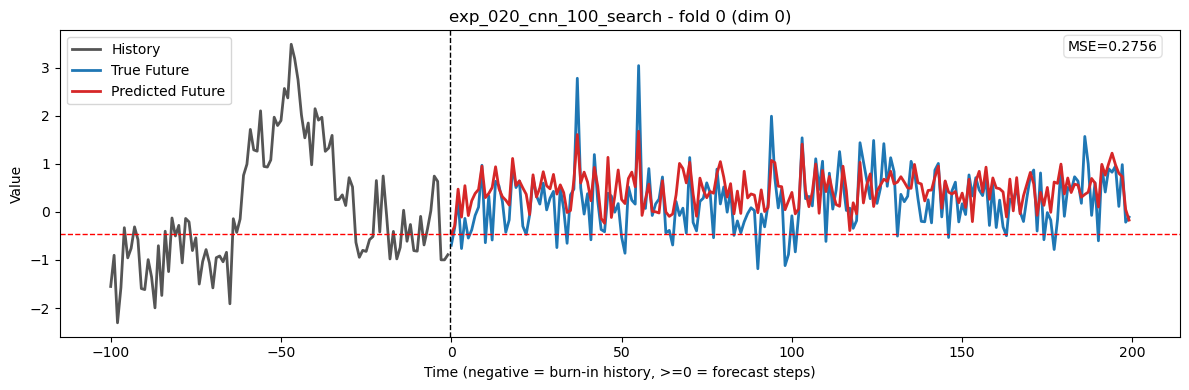

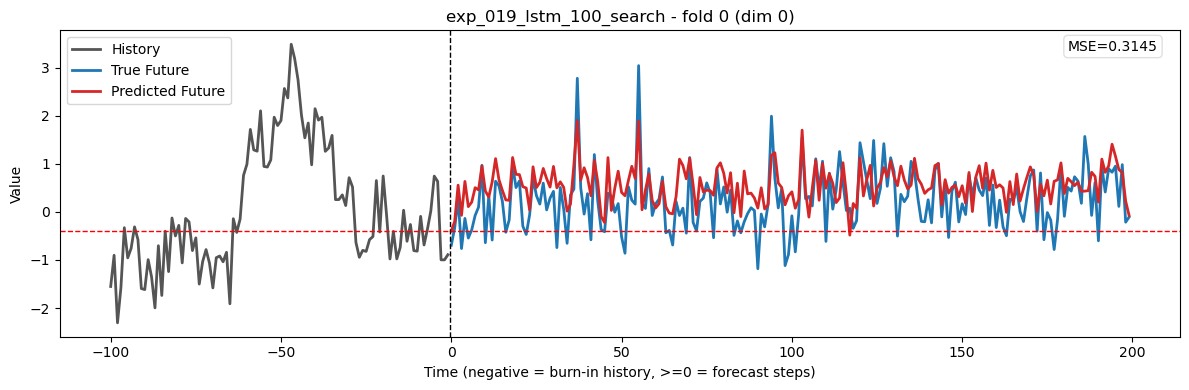

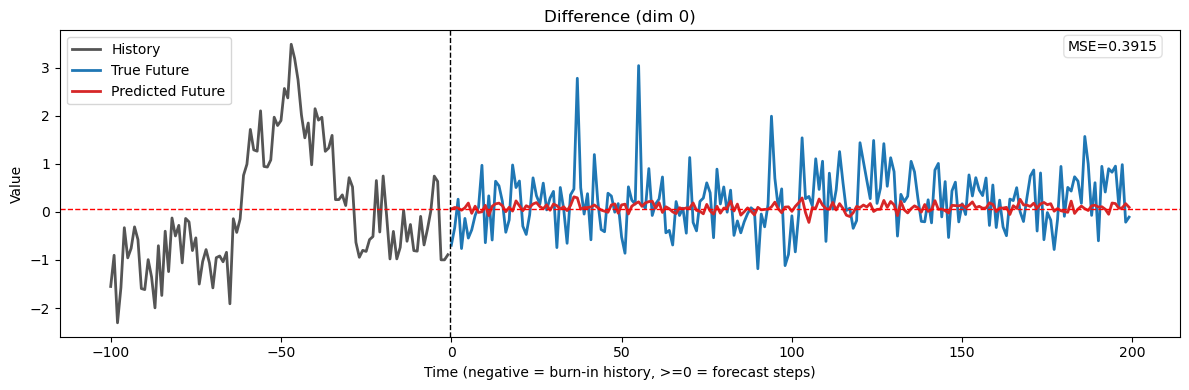

In [14]:

# Print
#plot_forecast_overlay(X_test_use[0], y_true_seq, y_pred_seq_ar_cnn, title=f"{name_cnn} - fold {fold_num} - PERMNO:{permno}")
#plot_forecast_overlay(X_test_use[0], y_true_seq, y_pred_seq_ar_lstm, title=f"{name_lstm} - fold {fold_num} - PERMNO:{permno}")
plot_forecast_overlay(X_test_use[0], y_true_seq, y_pred_seq_cnn, title=f"{name_cnn} - fold {fold_num}")
plot_forecast_overlay(X_test_use[0], y_true_seq, y_pred_seq_lstm, title=f"{name_lstm} - fold {fold_num}")
#plot_forecast_overlay(X_test_use[0], y_true_seq, y_pred_seq_muon, title=f"{name_lstm} - fold {fold_num} - PERMNO:{permno}")
plot_forecast_overlay(X_test_use[0], y_true_seq, diff, title=f"Difference")

<Axes: >

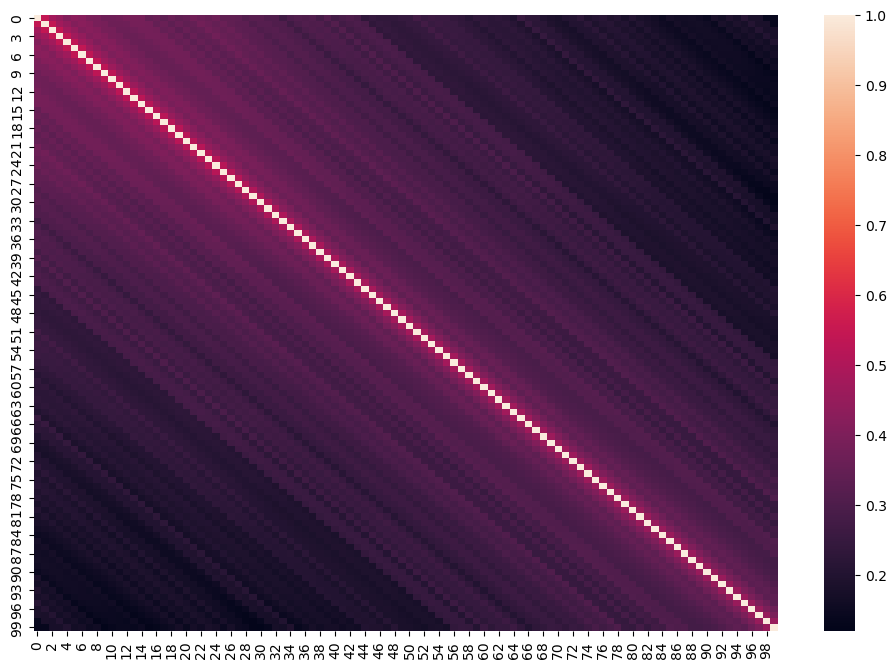

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(pd.DataFrame(Xtr_val).corr())

In [15]:
# Fit on merged train+val
Xtr_lin = _prepare_X_for_ols(Xtr_val)
ytr_lin = np.asarray(ytr_val)
ols = LinearRegression(fit_intercept=True).fit(Xtr_lin, ytr_lin)
lasso = Lasso(fit_intercept=True, alpha=0.05).fit(Xtr_lin, ytr_lin)

# Predict on the same test subset used above
Xte_lin = _prepare_X_for_ols(X_test_use)
yhat_te_ols = ols.predict(Xte_lin)
yhat_te_lasso = lasso.predict(Xte_lin)

mse_ols = mean_squared_error(y_test, yhat_te_ols)
mse_lasso = mean_squared_error(y_test, yhat_te_lasso)
print(f"Test OLS MSE: {mse_ols:.6f}")
print(f"Test Lasso MSE: {mse_lasso:.6f}")

KeyboardInterrupt: 

In [16]:

# Align shapes for plotting
y_true_lin = np.asarray(y_test_use[:len(X_test_use)])
if y_true_lin.ndim == 1:
    y_true_lin = y_true_lin.reshape(-1, 1)
if yhat_te_ols.ndim == 1:
    yhat_te_ols = yhat_te_ols.reshape(-1, 1)
    yhat_te_lasso = yhat_te_lasso.reshape(-1, 1)




plt.figure(figsize=(21,8))
sns.barplot(ols.coef_)
sns.barplot(lasso.coef_, alpha=0.6)
plot_forecast_overlay(X_test_use[0], y_true_lin, yhat_te_ols, title=f"OLS baseline - fold {fold_num} - PERMNO:{permno}")
plot_forecast_overlay(X_test_use[0], y_true_lin, yhat_te_lasso, title=f"lasso baseline - fold {fold_num} - PERMNO:{permno}")


NameError: name 'yhat_te_ols' is not defined

<Figure size 1000x600 with 0 Axes>

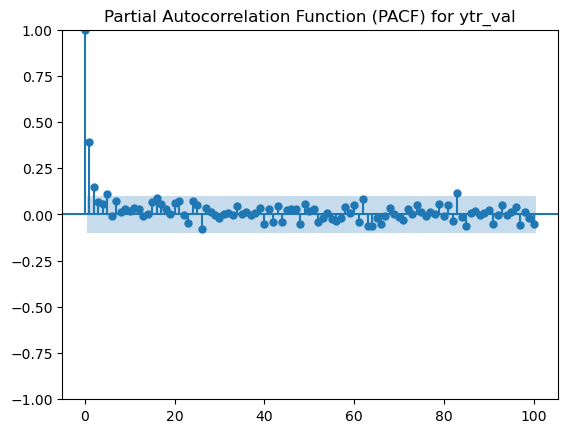

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

import matplotlib.pyplot as plt

# Plot PACF for ytr_val
plt.figure(figsize=(10, 6))
plot_pacf(y_test_use, lags=100, method='ywm', alpha=0.05)
plt.title("Partial Autocorrelation Function (PACF) for ytr_val")
plt.show()

In [17]:
@torch.inference_mode()
def probe_num(model, cfg, size, num=1, limit=None, autoregressive=False, device="cuda"):
    """
    Sequential single-row inference over chronologically sorted X_test.
    For autoregressive=True, we start from X_test[0] and then roll forward
    using our own predictions.
    Returns (y_true, preds) with shape (N, output_dim).
    """
    preds = []
    limit = size if limit is None else limit
    
    X_ar = None

    for i in range(limit):
        x_in = [0] * i + [num] + [0] *(limit-i-1)
        x_in = np.array(x_in)

        # Debug: check shapes
        # print("x_in shape:", np.asarray(x_in).shape)

        xb = _prepare_batch(cfg, x_in).to(device)  # should match training input shape
        pb = model(xb).detach().cpu().numpy().reshape(-1)  # (output_dim,)
        preds.append(pb)

        if autoregressive:
            # assume scalar output; if multi-dim adjust accordingly
            next_val = pb[0]

            # x_in is a window of length L; we drop the first element and append the prediction
            x_in = np.asarray(x_in)
            next_window = np.concatenate([x_in[1:], [next_val]])

            # store new window in buffer
            X_ar.append(next_window)

    preds = np.vstack(preds)  # (N, output_dim)

    return preds.reshape(-1)

@torch.inference_mode()
def test_random_uniform(model, cfg, size, low=-1.0, high=1.0, n_samples=100, seed=None, device="cuda"):
    """
    Feed the model random uniform noise vectors of dimension `size`.
    Returns predictions of shape (n_samples,).
    """
    if seed is not None:
        np.random.seed(seed)

    preds = []

    for _ in range(n_samples):
        x_in = np.random.uniform(low, high, size=size).astype(float)
        xb = _prepare_batch(cfg, x_in).to(device)
        pb = model(xb).detach().cpu().numpy().reshape(-1)
        preds.append(pb)

    preds = np.vstack(preds)  # (n_samples, output_dim)
    return preds.squeeze()



@torch.inference_mode()
def test_gaussian_noise(model, cfg, size, mean=0.0, std=1.0, n_samples=100, seed=None, device="cuda"):
    """
    Feed the model random Gaussian noise vectors N(mean, std^2)
    of dimension `size`.
    Returns predictions of shape (n_samples,).
    """
    if seed is not None:
        np.random.seed(seed)

    preds = []

    for _ in range(n_samples):
        x_in = np.random.normal(loc=mean, scale=std, size=size).astype(float)
        xb = _prepare_batch(cfg, x_in).to(device)
        pb = model(xb).detach().cpu().numpy().reshape(-1)
        preds.append(pb)

    preds = np.vstack(preds)
    return preds.squeeze()




In [18]:
from models import create_model
import json
from pathlib import Path

# Normalize MSE by target variance on each split
USE_NMSE = True
MERGE_TRAIN_VAL = False



# =========================
# Utilities
# =========================
def load_cfg(base) -> AppConfig:
    cfg_json = json.loads((base / "config_snapshot.json").read_text())
    return AppConfig.from_dict(cfg_json["cfg"])

def _infer_lstm_input_size_from_ckpt(state_dict: dict) -> int | None:
    # look for first LSTM weight_ih
    for k, v in state_dict.items():
        if k.endswith("lstm_layers.0.weight_ih_l0") or ("lstm_layers.0.weight_ih_l0" in k):
            # shape is [4*H, input_size]
            return int(v.shape[1])
    # legacy single-module naming (if any)
    for k, v in state_dict.items():
        if k.endswith("lstm.weight_ih_l0") or ("lstm.weight_ih_l0" in k):
            return int(v.shape[1])
    return None

def _make_input_shape_for_eval(cfg, X_sample: torch.Tensor | np.ndarray, state_dict: dict):
    name = cfg.model.name.lower()
    # infer T and (optional) D from the data
    if isinstance(X_sample, np.ndarray):
        shape = X_sample.shape
    else:
        shape = tuple(X_sample.shape)
    # shape is typically (N, T) or (N, T, D)
    if len(shape) == 2:
        _, T = shape
        D_data = 1
    elif len(shape) == 3:
        _, T, D_data = shape
    else:
        raise ValueError(f"Unexpected batch shape for X: {shape}")

    if name == "lstm":
        D_ckpt = _infer_lstm_input_size_from_ckpt(state_dict)
        D = D_ckpt if D_ckpt is not None else D_data  # prefer ckpt
        return (T, D)
    elif name == "simplecnn":
        # your CNN expects (C, L) with C=1
        return (1, T)
    elif name == "mlp":
        # your MLP code expects (T,) as before (flattened window)
        return (T,)
    else:
        raise ValueError(f"Unknown model name: {cfg.model.name}")

@torch.inference_mode()
def _predict_batched(model, X, device="cuda", bs=8192):
    preds = []
    for i in range(0, len(X), bs):
        xb = torch.as_tensor(X[i:i+bs], dtype=torch.float32, device=device)
        pb = model(xb).detach().cpu()
        preds.append(pb)
    return torch.cat(preds, dim=0).numpy()

def load_and_predict_nn(base_path, fold_idx, X_test, device="cuda"):
    """Load NN model for given fold and make predictions on test set."""
    try:
        base_path = Path(base_path)
        cfg = load_cfg(base_path)
        # Load checkpoint
        ckpt_path = base_path / f"fold_{fold_idx:03d}" / "model_best.pt"
        if not ckpt_path.exists():
            return None
        
        checkpoint = torch.load(ckpt_path, map_location=device)
        state_dict = {k.replace("_orig_mod.", ""): v for k, v in checkpoint["model_state"].items()}
        
        # Infer shapes
        input_shape = _make_input_shape_for_eval(cfg, X_test, state_dict)
        output_shape = cfg.walkforward.lookback + 1 if cfg.walkforward.lookback is not None else 1
        
        # Create and load model
        model = create_model(cfg.model, input_shape, output_shape)
        model.load_state_dict(state_dict, strict=True)
        model.to(device).eval()
        
        # Make predictions
        yhat = _predict_batched(model, X_test, device=device, bs=8192)
        
        # Cleanup
        del model, checkpoint
        torch.cuda.empty_cache()
        
        return yhat
        
    except Exception as e:
        print(f"Error loading/predicting fold {fold_idx}: {e}")
        return None


In [44]:
from sklearn.metrics import mean_squared_error
import os 
import json 

names = [name_lstm, name_lstm_muon]

fold_num = 0
checkpoints = []
base_paths = []
for name in names:
    try:
        base = f"{VOL_EXPERIMENTS_DIR}/{name}/trial_search_best/"
        ckpt_path = f"{base}fold_{fold_num:03d}/model_best.pt"
        checkpoint = torch.load(ckpt_path, map_location=DEVICE)
        checkpoints.append(checkpoint)
        base_paths.append(base)
        conifg_path = f"{base}config_snapshot.json"

        print(ckpt_path)
        with open(conifg_path, 'r') as f:
            cfg = json.load(f)

        cfg = cfg["cfg"]

        cfg = AppConfig.from_dict(cfg)
        print(f"optimizer: {cfg.trainer.hparams.get("optimizer_type")}")
        print(f"weight_decay: {cfg.trainer.hparams.get("weight_decay")}")
        print(f"learning rate: {cfg.trainer.hparams.get("lr")}")
        print()

    except FileNotFoundError:
        continue

def mse(y_true, y_pred, limit=None):
    # Use first output dim (adjust if you care about others)
    return mean_squared_error(y_true, y_pred)

models = []
for i, (ckpt, path) in enumerate(zip(checkpoints, base_paths)):
    model = build_model_from_checkpoint(cfg_lstm, ckpt, Xte[0])
    ytr_hat = load_and_predict_nn(path, 0, Xtr)
    yval_hat = load_and_predict_nn(path, 0, Xv)
    yte_hat = load_and_predict_nn(path, 0, Xte)

    # Use infer_sequential to predict y's and compute mse
    #y_true_seq_train, y_pred_seq_train = infer_sequential(model, cfg_lstm, Xtr, ytr)
    #y_true_seq_val, y_pred_seq_val = infer_sequential(model, cfg_lstm, Xv, yv)
    #y_true_seq_test, y_pred_seq_test = infer_sequential(model, cfg_lstm, Xte, yte)

    #mse_train_seq = mse(y_true_seq_train, y_pred_seq_train)
    #mse_val_seq = mse(y_true_seq_val, y_pred_seq_val)
    #mse_test_seq = mse(y_true_seq_test, y_pred_seq_test)

    models.append(model)
    mse_train = mse(ytr_hat, ytr)
    mse_val   = mse(yval_hat,  yv)
    mse_test  = mse(yte_hat, yte)

    print(f"Model {i}: train={mse_train:.6f}  val={mse_val:.6f}  test={mse_test:.6f}")
    #print(f"Sequential MSE: train={mse_train_seq:.6f}  val={mse_val_seq:.6f}  test={mse_test_seq:.6f}")



/orcd/home/002/corte911/code/finNN_code/src/volatility/experiments/exp_019_lstm_100_search/trial_search_best/fold_000/model_best.pt
optimizer: None
weight_decay: 1e-4
learning rate: 3e-3

/orcd/home/002/corte911/code/finNN_code/src/volatility/experiments/exp_026_lstm_100_muon/trial_search_best/fold_000/model_best.pt
optimizer: muon
weight_decay: 0.4219222674094878
learning rate: 0.002141168040468714

Model 0: train=0.430458  val=0.423090  test=0.379626
Model 0: train=0.430458  val=0.423090  test=0.379626
Model 1: train=0.432204  val=0.420645  test=0.379937
Model 1: train=0.432204  val=0.420645  test=0.379937


In [38]:
from sklearn.metrics import mean_squared_error
import os 
import json 

name = "exp_026_lstm_100_muon"

fold_num = 0
checkpoints = []
base_paths = []
for trial in os.listdir(f"{VOL_EXPERIMENTS_DIR}/{name}")[12:16]:
    try:
        base = f"{VOL_EXPERIMENTS_DIR}/{name}/{trial}/"
        ckpt_path = f"{base}fold_{fold_num:03d}/model_best.pt"
        checkpoint = torch.load(ckpt_path, map_location=DEVICE)
        checkpoints.append(checkpoint)
        base_paths.append(base)
        conifg_path = f"{base}config_snapshot.json"

        print(ckpt_path)
        with open(conifg_path, 'r') as f:
            cfg = json.load(f)

        cfg = cfg["cfg"]

        cfg = AppConfig.from_dict(cfg)
        print(f"optimizer: {cfg.trainer.hparams.get("optimizer_type")}")
        print(f"weight_decay: {cfg.trainer.hparams.get("weight_decay")}")
        print(f"learning rate: {cfg.trainer.hparams.get("lr")}")
        print()

    except FileNotFoundError:
        continue

def mse(y_true, y_pred, limit=None):
    # Use first output dim (adjust if you care about others)
    return mean_squared_error(y_true, y_pred)

models = []
for i, (ckpt, path) in enumerate(zip(checkpoints, base_paths)):
    model = build_model_from_checkpoint(cfg_lstm, ckpt, Xte[0])
    ytr_hat = load_and_predict_nn(path, 0, Xtr)
    yval_hat = load_and_predict_nn(path, 0, Xv)
    yte_hat = load_and_predict_nn(path, 0, Xte)

    # Use infer_sequential to predict y's and compute mse
    #y_true_seq_train, y_pred_seq_train = infer_sequential(model, cfg_lstm, Xtr, ytr)
    #y_true_seq_val, y_pred_seq_val = infer_sequential(model, cfg_lstm, Xv, yv)
    #y_true_seq_test, y_pred_seq_test = infer_sequential(model, cfg_lstm, Xte, yte)

    #mse_train_seq = mse(y_true_seq_train, y_pred_seq_train)
    #mse_val_seq = mse(y_true_seq_val, y_pred_seq_val)
    #mse_test_seq = mse(y_true_seq_test, y_pred_seq_test)

    models.append(model)
    mse_train = mse(ytr_hat, ytr)
    mse_val   = mse(yval_hat,  yv)
    mse_test  = mse(yte_hat, yte)

    print(f"Model {i}: train={mse_train:.6f}  val={mse_val:.6f}  test={mse_test:.6f}")
    #print(f"Sequential MSE: train={mse_train_seq:.6f}  val={mse_val_seq:.6f}  test={mse_test_seq:.6f}")



/orcd/home/002/corte911/code/finNN_code/src/volatility/experiments/exp_026_lstm_100_muon/trial_000_010/fold_000/model_best.pt
optimizer: muon
weight_decay: 0.4219222674094878
learning rate: 0.002141168040468714

/orcd/home/002/corte911/code/finNN_code/src/volatility/experiments/exp_026_lstm_100_muon/trial_000_012/fold_000/model_best.pt
optimizer: muon
weight_decay: 2.593797603919469
learning rate: 0.0022267772537493125

/orcd/home/002/corte911/code/finNN_code/src/volatility/experiments/exp_026_lstm_100_muon/trial_000_013/fold_000/model_best.pt
optimizer: muon
weight_decay: 0.5897846261679597
learning rate: 0.04640048657370026

Model 0: train=0.432840  val=0.426662  test=0.382375
Model 0: train=0.432840  val=0.426662  test=0.382375
Model 1: train=0.423789  val=0.426411  test=0.383217
Model 1: train=0.423789  val=0.426411  test=0.383217
Model 2: train=0.447644  val=0.434155  test=0.389734
Model 2: train=0.447644  val=0.434155  test=0.389734


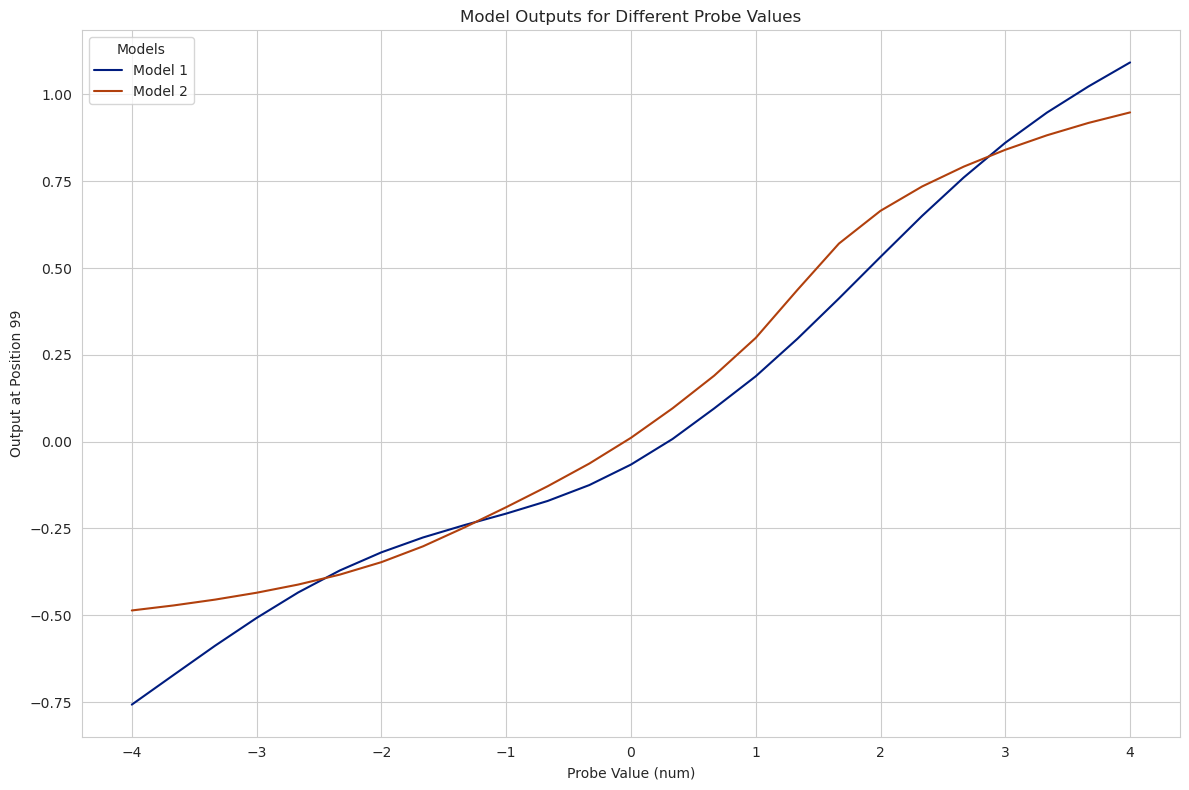

In [45]:
size = 100
ys = []
nums = np.linspace(-4, 4, 25)
sns.set_palette("dark")
plt.figure(figsize=(12, 8))  # Set a larger figure size

for i, model in enumerate(models):
    inner_ys = []
    for n in nums:         
        y = probe_num(model, cfg_lstm, size, num=n).ravel()[99]
        inner_ys.append(y)

    ys.append(inner_ys)
    sns.lineplot(x=nums, y=inner_ys, label=f"Model {i+1}")  # Add legend for each model

plt.xlabel("Probe Value (num)")
plt.ylabel("Output at Position 99")
plt.title("Model Outputs for Different Probe Values")
plt.legend(title="Models")  # Add a legend with a title
plt.grid(True)
plt.tight_layout()
plt.show()


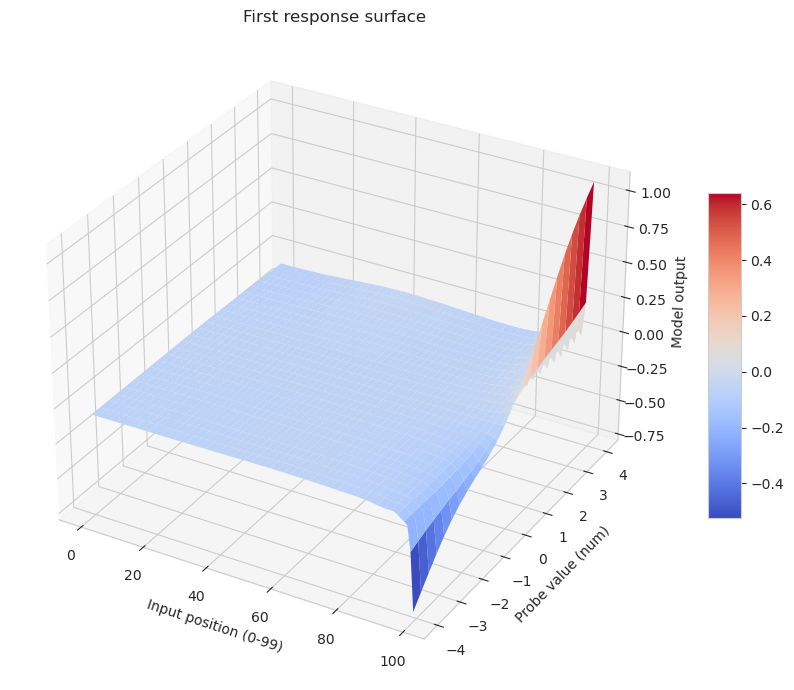

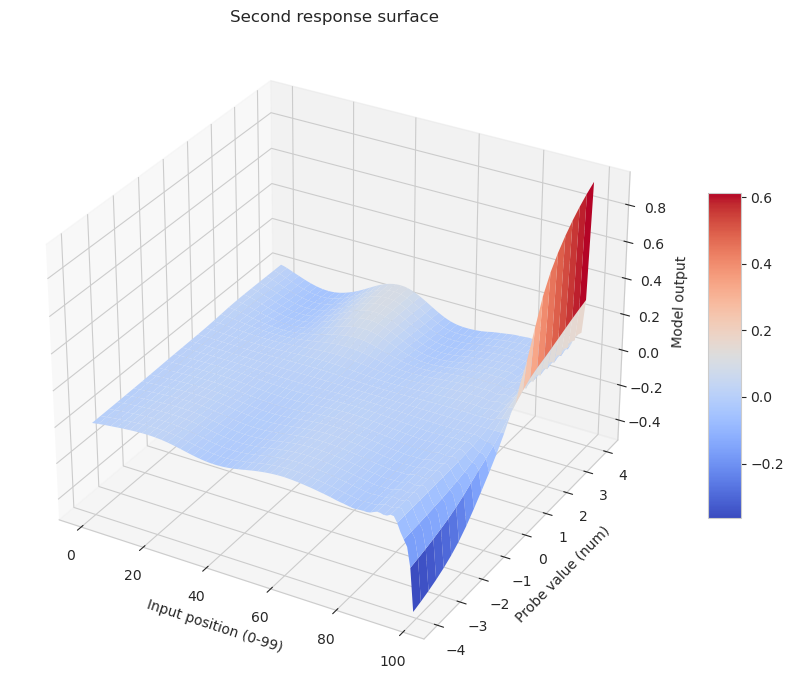

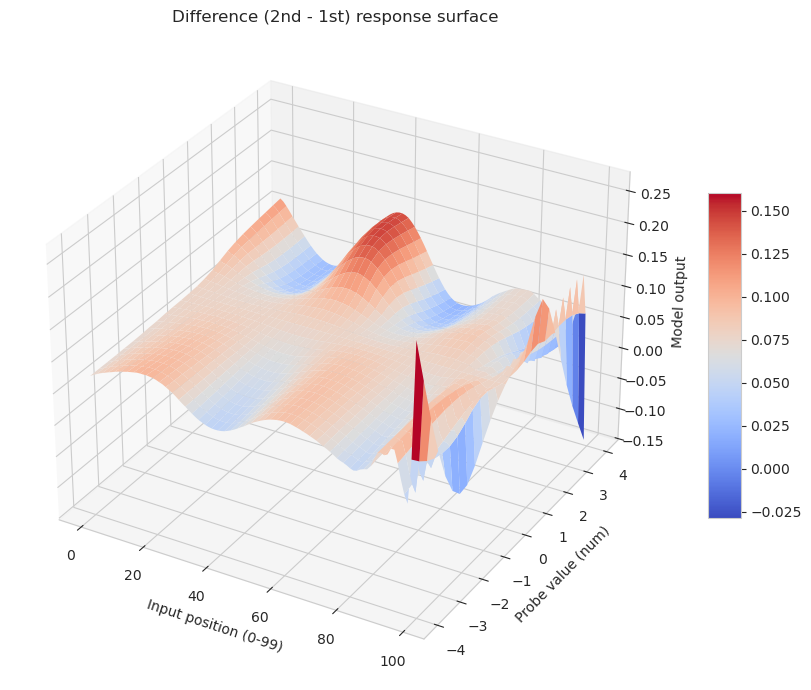

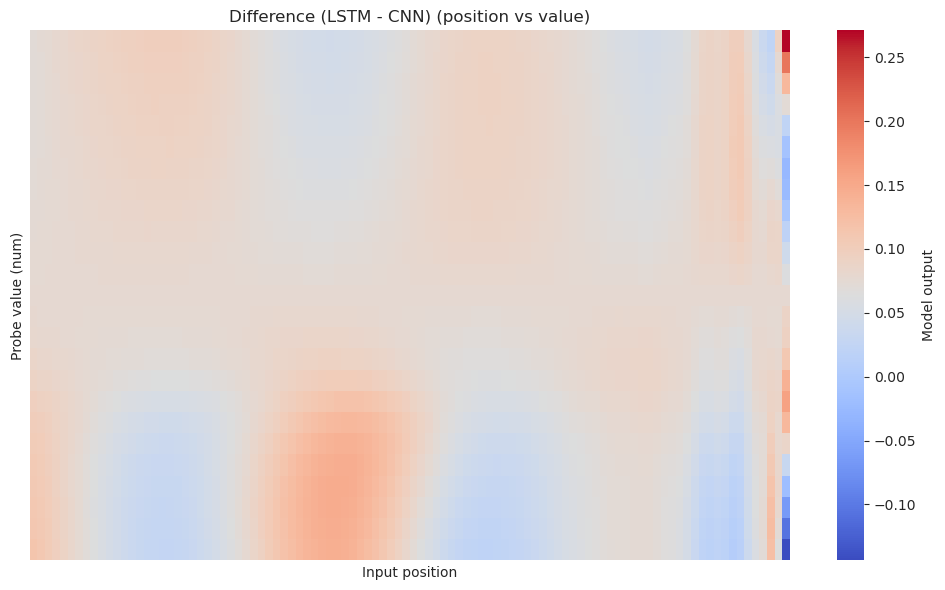

np.float64(3.898549733883863)

In [46]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed for 3d projection

# Set a prettier palette
sns.set_palette("coolwarm")
sns.set_style("whitegrid")

nums = np.linspace(-4, 4, 25)   # values you’re probing
size = 100                      # input dimension

Z_first = np.zeros((len(nums), size))
Z_second = np.zeros((len(nums), size))
Z_diff = np.zeros((len(nums), size))

for i, n in enumerate(nums):
    # assuming probe_num returns shape (size,) or (size,1)
    y_first = probe_num(models[0], cfg_lstm, size, num=n).ravel()
    y_second = probe_num(models[1], cfg_lstm, size, num=n).ravel()

    Z_first[i, :] = y_first
    Z_second[i, :] = y_second
    Z_diff[i, :] = y_second - y_first

X, Y = np.meshgrid(np.arange(size), nums)  # X: position, Y: num

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z_first, cmap="coolwarm", linewidth=0, antialiased=True)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_xlabel("Input position (0-99)")
ax.set_ylabel("Probe value (num)")
ax.set_zlabel("Model output")
ax.set_title("First response surface")
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z_second, cmap="coolwarm", linewidth=0, antialiased=True)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_xlabel("Input position (0-99)")
ax.set_ylabel("Probe value (num)")
ax.set_zlabel("Model output")
ax.set_title("Second response surface")
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z_diff, cmap="coolwarm", linewidth=0, antialiased=True)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_xlabel("Input position (0-99)")
ax.set_ylabel("Probe value (num)")
ax.set_zlabel("Model output")
ax.set_title("Difference (2nd - 1st) response surface")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(Z_diff, cmap="coolwarm", cbar_kws={'label': 'Model output'}, 
            xticklabels=False, yticklabels=False)
plt.xlabel("Input position")
plt.ylabel("Probe value (num)")
plt.title("Difference (LSTM - CNN) (position vs value)")
plt.tight_layout()
plt.show()

np.linalg.norm(Z_diff.reshape(-1,1))

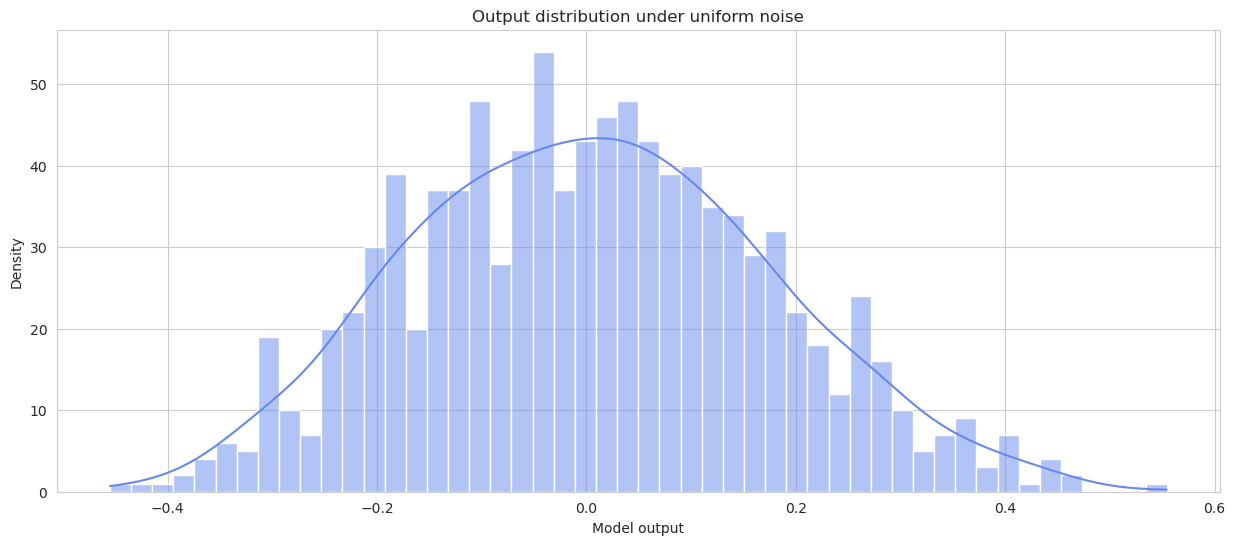

In [ ]:
y_uni = test_random_uniform(model_cnn, cfg_cnn, size=100, n_samples=1000, low=-1, high=1)

plt.figure(figsize=(15,6))
sns.histplot(y_uni, bins=50, kde=True)
plt.xlabel("Model output")
plt.ylabel("Density")
plt.title("Output distribution under uniform noise")
plt.grid(True)
plt.show()


- Gaussian noise is very similar to the orginal input becuase the autocorrelation among features is not statistically significant for the majority of them.

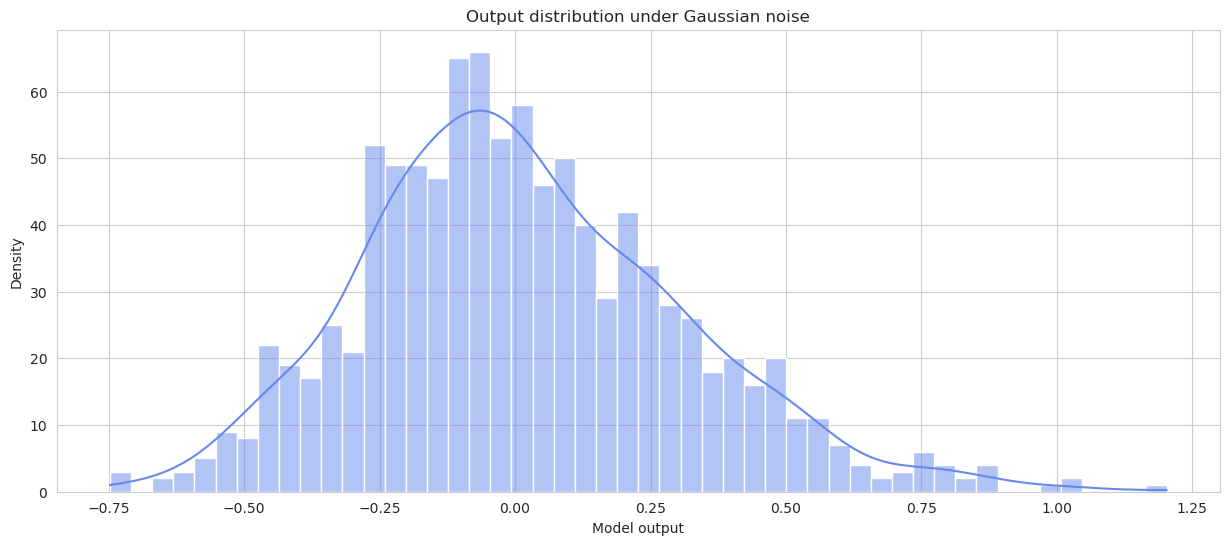

In [ ]:
y_gauss = test_gaussian_noise(model_cnn, cfg_cnn, size=100, n_samples=1000, mean=0.0, std=1)

plt.figure(figsize=(15,6))
sns.histplot(y_gauss, bins=50, kde=True)
plt.xlabel("Model output")
plt.ylabel("Density")
plt.title("Output distribution under Gaussian noise")
plt.grid(True)
plt.show()


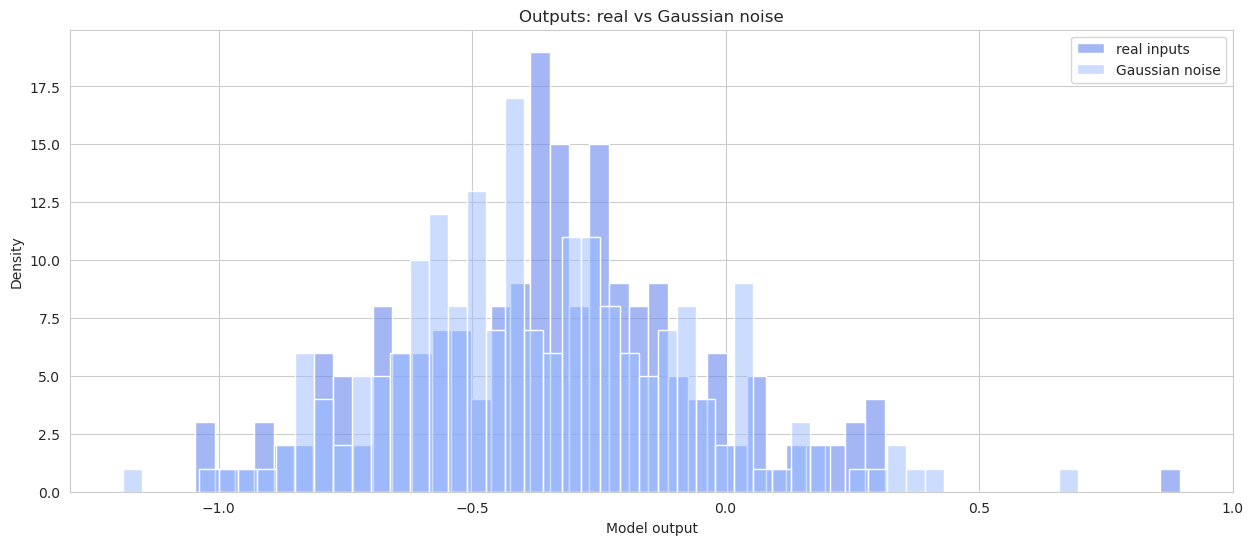

In [ ]:
# Predictions on real test data (first N samples)
N = 200
y_true_real, y_pred_real = infer_sequential(model_cnn, cfg_cnn, X_test_use, y_test_use, limit=N, autoregressive=False)
y_pred_real = y_pred_real[:, 0]  # scalar output

# Predictions on Gaussian noise
y_gauss = test_gaussian_noise(model_cnn, cfg_cnn, size=X_test_use[0].shape[-1],
                              mean=X_test_use[0].mean(), std=1, n_samples=N)

plt.figure(figsize=(15,6))
sns.histplot(y_pred_real, bins=50, alpha=0.6, label="real inputs")
sns.histplot(y_gauss,     bins=50, alpha=0.5, label="Gaussian noise")
plt.xlabel("Model output")
plt.ylabel("Density")
plt.title("Outputs: real vs Gaussian noise")
plt.legend()
plt.grid(True)
plt.show()


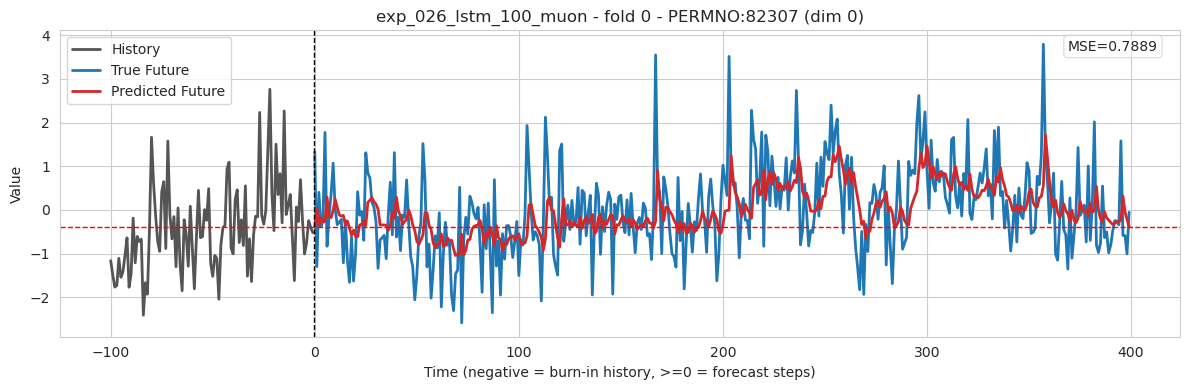

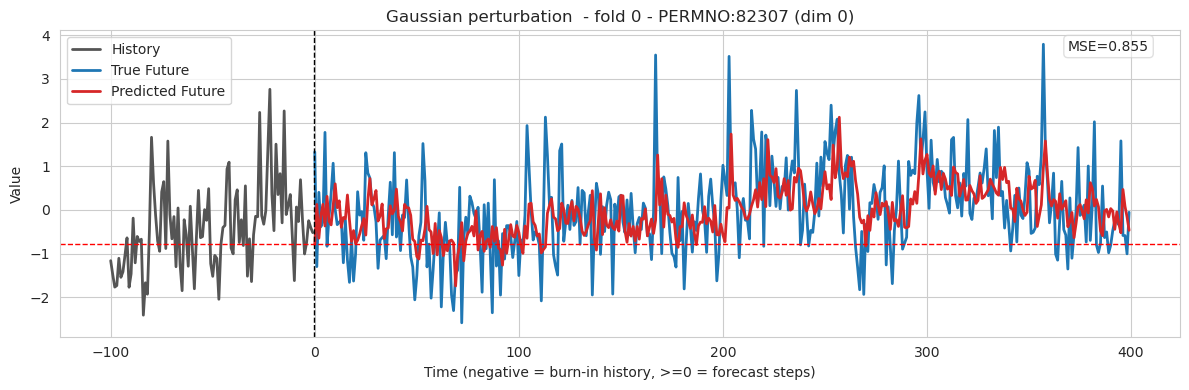

In [ ]:
def compute_empirical_cov(X):
    """
    X is a list/array of inputs X[i], each can be 1D or 2D;
    we flatten them to compute covariance.
    """
    X_flat = np.array([np.ravel(x) for x in X])  # (N, D)
    mu = X_flat.mean(axis=0)
    cov = np.cov(X_flat, rowvar=False)          # (D, D)
    return mu, cov

@torch.inference_mode()
def perturbate_input(model, cfg, X_test, y_test, limit=None, device="cuda", perturbation="gaussian"):
    """
    Sequential single-row inference over chronologically sorted X_test.
    For autoregressive=True, we start from X_test[0] and then roll forward
    using our own predictions.
    Returns (y_true, preds) with shape (N, output_dim).
    """
    preds = []
    limit = len(X_test) if limit is None else limit

    perturbation = perturbation.lower()

    allowed = ["gaussian", "uniform"]
    assert perturbation in allowed, f"Only {allowed} are allowed as perturbation."

    if perturbation == "gaussian":
        mu, sigma = compute_empirical_cov(X_test)
    
    for i in range(limit):
        x_in = X_test[i]
        if perturbation == "gaussian":
            p = np.random.multivariate_normal(mean=mu, cov=sigma)
            x_in = x_in + p*0.5

        # Debug: check shapes
        # print("x_in shape:", np.asarray(x_in).shape)

        xb = _prepare_batch(cfg, x_in).to(device)  # should match training input shape
        pb = model(xb).detach().cpu().numpy().reshape(-1)  # (output_dim,)
        preds.append(pb)


    preds = np.vstack(preds)  # (N, output_dim)
    y_true = np.asarray(y_test[:limit])
    if y_true.ndim == 1:
        y_true = y_true.reshape(-1, 1)

    return y_true, preds


y_true_per, y_pred_per = perturbate_input(model_cnn, cfg_cnn, X_test_use, y_test_use)
y_true_seq, y_pred_seq_cnn = infer_sequential(model_cnn, cfg_cnn, X_test_use, y_test_use)

# Print
plot_forecast_overlay(X_test_use[0], y_true_seq, y_pred_seq_cnn, title=f"{name} - fold {fold_num} - PERMNO:{permno}")
plot_forecast_overlay(X_test_use[0], y_true_per, y_pred_per, title=f"Gaussian perturbation  - fold {fold_num} - PERMNO:{permno}")

In [ ]:
# Utility: print checkpoint paths for different models/trials
import os
from pathlib import Path

fold_num = 0  # adjust as needed

experiments = {
    # label: (experiment_folder, trial_folder)
    "mlp_best": ("exp_033_mlp_100_muon", "trial_search_best"),
    "cnn_best": ("exp_020_cnn_100_search", "trial_search_best"),
    "cnn_trial_000_003": ("exp_020_cnn_100_search", "trial_000_003"),
    "lstm_best": ("exp_019_lstm_100_search", "trial_search_best"),
    "lstm_muon_best": ("exp_026_lstm_100_muon", "trial_search_best"),
}

print("Per-label explicit checkpoint paths:\n")
for label, (exp_name, trial_name) in experiments.items():
    ckpt_path = f"{VOL_EXPERIMENTS_DIR}/{exp_name}/{trial_name}/fold_{fold_num:03d}/model_best.pt"
    exists = os.path.exists(ckpt_path)
    print(f"{label:18s} -> {ckpt_path}  [{'OK' if exists else 'MISSING'}]")

print("\nEnumerating all trial subdirectories for each experiment (showing existing checkpoints):\n")
for label, (exp_name, _trial_name) in experiments.items():
    exp_root = Path(VOL_EXPERIMENTS_DIR) / exp_name
    if not exp_root.exists():
        print(f"{label}: experiment root missing: {exp_root}")
        continue
    trial_dirs = sorted([p for p in exp_root.iterdir() if p.is_dir()])
    print(f"{label} ({exp_name})")
    found_any = False
    for tdir in trial_dirs:
        ckpt = tdir / f"fold_{fold_num:03d}" / "model_best.pt"
        if ckpt.exists():
            found_any = True
            print(f"  trial={tdir.name:20s} -> {ckpt}")
    if not found_any:
        print("  (no checkpoints for this fold)")
    print("")

# Optional: collect all existing paths into a dict for later use
all_checkpoint_paths = {}
for label, (exp_name, _trial_name) in experiments.items():
    exp_root = Path(VOL_EXPERIMENTS_DIR) / exp_name
    if not exp_root.exists():
        continue
    for tdir in exp_root.iterdir():
        if not tdir.is_dir():
            continue
        ckpt = tdir / f"fold_{fold_num:03d}" / "model_best.pt"
        if ckpt.exists():
            key = f"{exp_name}:{tdir.name}:fold_{fold_num:03d}"
            all_checkpoint_paths[key] = str(ckpt)

print("Collected", len(all_checkpoint_paths), "checkpoint paths.")
# Preview first few
for i, (k, v) in enumerate(all_checkpoint_paths.items()):
    if i >= 10:
        break
    print(f"{k} -> {v}")

Per-label explicit checkpoint paths:

mlp_best           -> /orcd/home/002/corte911/code/finNN_code/src/volatility/experiments/exp_033_mlp_100_muon/trial_search_best/fold_000/model_best.pt  [OK]
cnn_best           -> /orcd/home/002/corte911/code/finNN_code/src/volatility/experiments/exp_020_cnn_100_search/trial_search_best/fold_000/model_best.pt  [OK]
cnn_trial_000_003  -> /orcd/home/002/corte911/code/finNN_code/src/volatility/experiments/exp_020_cnn_100_search/trial_000_003/fold_000/model_best.pt  [MISSING]
lstm_best          -> /orcd/home/002/corte911/code/finNN_code/src/volatility/experiments/exp_019_lstm_100_search/trial_search_best/fold_000/model_best.pt  [OK]
lstm_muon_best     -> /orcd/home/002/corte911/code/finNN_code/src/volatility/experiments/exp_026_lstm_100_muon/trial_search_best/fold_000/model_best.pt  [OK]

Enumerating all trial subdirectories for each experiment (showing existing checkpoints):

mlp_best (exp_033_mlp_100_muon)
  trial=trial_000_000        -> /orcd/home/00

In [ ]:
# Path extraction utilities for experiment/trial identification
import re
from pathlib import Path

sample_path = "/orcd/home/002/corte911/code/finNN_code/src/volatility/experiments/exp_026_lstm_100_muon/trial_000_010/fold_000/model_best.pt"

def extract_exp_trial(path: str) -> str | None:
    """Return 'exp_XXX.../trial_YYY_ZZZ' from a full checkpoint path.
    Searches for the segment after 'experiments/'."""
    parts = Path(path).parts
    for i, part in enumerate(parts):
        if part == "experiments":
            # Expect next two parts: experiment directory and trial directory
            exp = parts[i+1] if i+1 < len(parts) else None
            trial = parts[i+2] if i+2 < len(parts) else None
            if exp and trial and trial.startswith("trial_"):
                return f"{exp}/{trial}"
            return None
    return None

def extract_exp_trial_regex(path: str) -> str | None:
    """Regex alternative: capture experiment and trial segments."""
    m = re.search(r"/experiments/([^/]+/(trial_\d{3}_\d{3}))", path)
    return m.group(1) if m else None

def extract_components(path: str):
    """Return tuple (experiment, trial) or (None, None)."""
    parts = Path(path).parts
    for i, part in enumerate(parts):
        if part == "experiments":
            exp = parts[i+1] if i+1 < len(parts) else None
            trial = parts[i+2] if i+2 < len(parts) and parts[i+2].startswith("trial_") else None
            return exp, trial
    return None, None

print("Sample path:\n", sample_path)
print("extract_exp_trial       ->", extract_exp_trial(sample_path))
print("extract_exp_trial_regex ->", extract_exp_trial_regex(sample_path))
print("extract_components      ->", extract_components(sample_path))

# Robust list extraction from currently collected checkpoints if available
if 'all_checkpoint_paths' in globals():
    print("\nBatch extraction over collected checkpoint paths:")
    for key, p in list(all_checkpoint_paths.items())[:15]:  # preview first 15
        print(f"{p} -> {extract_exp_trial(p)}")


Sample path:
 /orcd/home/002/corte911/code/finNN_code/src/volatility/experiments/exp_026_lstm_100_muon/trial_000_010/fold_000/model_best.pt
extract_exp_trial       -> exp_026_lstm_100_muon/trial_000_010
extract_exp_trial_regex -> exp_026_lstm_100_muon/trial_000_010
extract_components      -> ('exp_026_lstm_100_muon', 'trial_000_010')

Batch extraction over collected checkpoint paths:
/orcd/home/002/corte911/code/finNN_code/src/volatility/experiments/exp_033_mlp_100_muon/trial_000_000/fold_000/model_best.pt -> exp_033_mlp_100_muon/trial_000_000
/orcd/home/002/corte911/code/finNN_code/src/volatility/experiments/exp_033_mlp_100_muon/trial_000_001/fold_000/model_best.pt -> exp_033_mlp_100_muon/trial_000_001
/orcd/home/002/corte911/code/finNN_code/src/volatility/experiments/exp_033_mlp_100_muon/trial_000_002/fold_000/model_best.pt -> exp_033_mlp_100_muon/trial_000_002
/orcd/home/002/corte911/code/finNN_code/src/volatility/experiments/exp_033_mlp_100_muon/trial_000_003/fold_000/model_best.pt